In [1]:
#this program takes the dushinsky matrix and displacement vector as input
#calculates the covariance matrix and displacement vector after the transformation given by the dushinsky matrix
#calculates the reduced covariance and displacement for given modes (spins)
#calculates the statistics of photons for given modes (spins)
#uses matching pursuit with brute force argmax maximization (only pairs of modes)
#or matching pursuit with Ising for nn modes, not necessary 2 nn
#finds the joint distribution
#expresses it in terms of energies


import matplotlib.pyplot as plt
import numpy as np
import wojciech_remastered as wo

import numpy as np
from qiskit.quantum_info.operators.symplectic import SparsePauliOp
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from bitstring import BitArray
from collections import Counter
import copy

In [2]:
N = 4 # dimensionality of a mode (cutoff)
M = 7  # number of modes

In [3]:
#data
U = np.array([[0.9934,0.0144,0.0153,0.0286,0.0638,0.0751,-0.0428],
 [-0.0149,0.9931,0.0742,0.0769,-0.0361,-0.0025,0.0173],
 [-0.0119,-0.0916,0.8423,0.1799,-0.3857,0.3074,0.0801],
 [0.0381,0.0409,-0.3403,-0.5231,-0.6679,0.3848,0.1142],
 [-0.0413,-0.0342,-0.4004,0.7636,-0.1036,0.4838,0.0941],
 [0.0908,-0.0418,-0.0907,0.3151,-0.5900,-0.7193,0.1304],
 [-0.0325,0.0050,-0.0206,0.0694,-0.2018,0.0173,-0.9759]])
   
omegabis = np.array([3765.2386,3088.1826,1825.1799,1416.9512,1326.4684,1137.0490,629.7144])
omegaprim = np.array([3629.9472,3064.9143,1566.4602,1399.6554,1215.3421,1190.9077,496.2845])
delta = np.array([0.2254,0.1469,1.5599,-0.3784,0.4553,-0.3439,0.0618])
J = np.sqrt(np.diag(omegaprim))@U@np.sqrt(np.diag(np.power(omegabis,-1)))

Alfa = (J - np.linalg.inv(J.T))/2
Beta = (J + np.linalg.inv(J.T))/2

In [4]:
#Evolution Op
S = np.block([[Alfa,Beta],[Beta.T,Alfa.T]])
dela = np.array(2*list(delta))

#Initial
cov = np.identity(2*M)
mu = np.zeros(2*M)

#Applying evolution
cov = S@cov@S.T   #covariance matrix
mu = S@mu + dela   #displacement vector

In [5]:
#Zero proba
num = np.exp(- 0.5 * mu @ np.linalg.inv(cov + np.diag(np.ones(2 * M)))@ mu)
denom = np.linalg.det(cov + np.diag(np.ones(2 * M)))
proba_zero = (2**M * num) / np.sqrt(denom)

In [6]:
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]

def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats

def create_specific_patterns4(mode1,mode2,mode3,mode4,size):
    pats = []
    temp_pats = create_specific_patterns3(mode1,mode2,mode3,size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode4] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats

def underpattern(pats):
    pats = [[t if i not in [0,1,2,3] else [1,0] for i,t in enumerate(p)] for p in pats]
    patterns = []
    for p in pats:
        if p not in patterns:
            patterns.append(p)
    return patterns

def is_all_zeros(pat):
    for t in pat:
        if t!=[1,1] and t!=[1,0]:
            return False
    return True


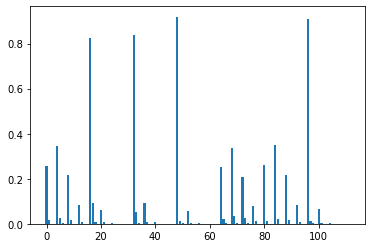

In [7]:
#Marginals
spins = [[3,4],[4,5],[5,6],[6,7],[3,5],[3,6],[4,7]]    #with this choice support detection in the matching pursuit corresponds to the Ising problem with nearest neighbours
# l = np.arange(1,M)
# spins = []
# for i in range(10):
#     np.random.shuffle(l)
#     r = l[0:2]
#     r.sort()
#     spins += [[r[0],r[1]]]
# print(spins)
# spins = [[2, 3], [1, 3], [3, 6], [1, 3], [1, 3], [1, 6], [3, 4], [1, 6], [2, 3], [2, 5]]

nn = len(spins[0])
y = wo.Marginals(spins, N, cov, mu,0)

#pattern of the form ai = (1 0 0 0)@(0 0 1 0)@(1 1 1 1)@....
#recover pattern and compute the hamiltonian H = Sum yi*ai  --> can not do that, spin-4 operators
#QAOA

NbQ = int(np.log2(N**M))
all_pat = []
for s in spins:
    all_pat+=underpattern(create_specific_patterns4( (s[0]-1)*2,(s[0]-1)*2+1,(s[1]-1)*2,(s[1]-1)*2+1,NbQ))

# all_pat2 = []
# y2 = []
# for yi,pat in zip(y,all_pat):
#     if not is_all_zeros(pat):
#         all_pat2.append(pat)
#         y2.append(yi)
# all_pat = all_pat2
# y = np.array(y2)

A = np.matrix([ dev_pattern(p) for p in all_pat])

plt.bar(np.arange(len(y)),y)
plt.show()

In [11]:
for i in range(16,32):
    plt.plot(np.arange(len(dev_pattern(all_pat[0]))),dev_pattern(all_pat[i]))
    plt.show()

256


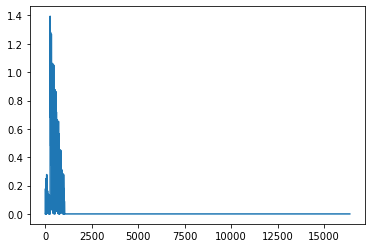

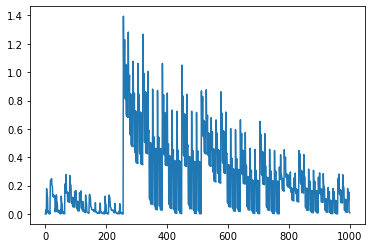

In [129]:
a = np.zeros(16384)
for yi,pat in zip(y,all_pat):
    a+= dev_pattern(pat)*yi

print(a.argmax())
plt.plot(np.arange(16384),a)
plt.show()

plt.plot(np.arange(1000),a[:1000])
plt.show()

256
0
512
256
0
512
256
768
0
256
512
784
256
528
0


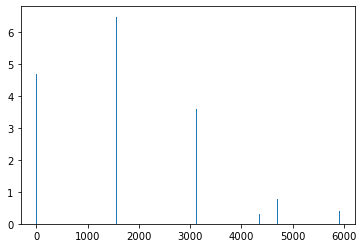

In [10]:
def matching_pursuit(y,A):

    x_recov = {}
    r = copy.deepcopy(y)

    for i in range(15):

        v = np.argmax(A.T * r)
        print(v)

        x_recov[v] = (A.T[v]*r)[0,0] if (v not in x_recov) else x_recov[v]+(A.T[v]*r)[0,0]
        r -= (0.05*((A.T[v]*r)[0,0]) * A.T[v]).T

    return x_recov

x_recov = matching_pursuit(np.matrix(y).T,A)
x_recov = np.array(list(x_recov.items()))
eng = np.array([omegaprim @ wo.Num2sth(xi[0], N, M, 'R') for xi in x_recov])
plt.bar(eng,x_recov[:,1],width = 20)
plt.show()

In [115]:
#*** MATCHING PURSUIT ***
st = 0.01  #step
itnum = 80 #number of iterations

x = wo.Matchpurising(y,st,itnum,M-2, N,nn)
x = np.append(x,[0,proba_zero]).reshape((-1,2))
x

array([[1.60000000e+01, 3.30000000e-01],
       [0.00000000e+00, 2.30000000e-01],
       [3.20000000e+01, 1.70000000e-01],
       [4.80000000e+01, 4.00000000e-02],
       [3.30000000e+01, 2.00000000e-02],
       [4.90000000e+01, 1.00000000e-02],
       [0.00000000e+00, 2.08203161e-01]])

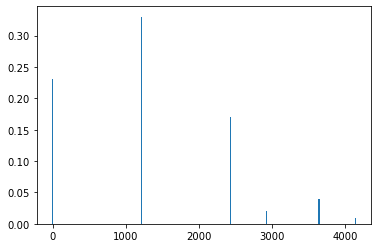

In [116]:
#spectrum in terms of energy
eng = np.array([omegaprim @ wo.Num2sth(xi[0], N, M, 'R') for xi in x])
plt.bar(eng,x[:,1],width = 20)
plt.show()

In [149]:
def decomposition(mat):
    a,b,c,d = mat[0],mat[1],mat[2],mat[3]
    return 1/4 * np.array( [a+b+c+d, a+b-c-d, a-b+c-d, a-b-c+d] )
def compute_hamiltonian(all_pat,y):

    H = 0

    for p,yi in zip(all_pat,y):
        
        if yi[0,0]==0:
            continue

        ops = []
        for t in p[4:]:
            if t == [0,1]:
                coefs = [1/2,-1/2]
            elif t == [1,0]:
                coefs = [1/2,1/2]
            else:
                coefs = [1,0]
            ops.append(SparsePauliOp(["I","Z"],coefs))
        op = ops[0]

        for i in range(1,len(ops)):
            op = op.tensor(ops[i]).simplify()
        H = (H + (op * yi[0,0])).simplify()

    H = H.simplify(atol=0, rtol=0)
    return np.real_if_close(H.coeffs),H.paulis


y = np.matrix(y).T if len(y.shape)==1 else y
H,paulis_idx = compute_hamiltonian(all_pat,y)
# for pstring,coef in zip(paulis_idx,H):
#     print(pstring,coef)
len(H)

97

In [12]:
def paulis_to_gates(pauli_string):
    return [i for i,s in enumerate(pauli_string) if s=='Z']


def obj_func(z):
    v = BitArray(bin='0'+z).int
    return (A.T[v]*y)[0,0]


def compute_expectation(counts):
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = -obj_func(bitstring)
        avg += obj * count
        sum_count += count
    # print(avg/sum_count)
    return avg/sum_count

def create_qaoa_circ(theta,paulis_idx,H):

    nqubits = 10
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

        for pstring,coef in zip(paulis_idx,H):
            if coef!=0:
                idx = paulis_to_gates(str(pstring))
                if len(idx)==1:
                    qc.rz(2*gamma[irep]*coef,idx[0])
                elif len(idx)==2:
                    qc.rzz(2*gamma[irep]*coef,idx[0],idx[1])
                elif len(idx)==3:
                    qc.cnot(idx[0],idx[1])
                    qc.cnot(idx[1],idx[2])
                    qc.rz(2*gamma[irep]*coef,idx[2])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[0],idx[1])
                elif len(idx)==4:
                    qc.cnot(idx[0],idx[1])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[2],idx[3])
                    qc.rz(2*gamma[irep]*coef,idx[3])
                    qc.cnot(idx[2],idx[3])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[0],idx[1])

    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(paulis_idx,H,shots=512):
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta,paulis_idx,H)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts)
    
    return execute_circ

In [177]:
y = np.matrix(y).T if len(y.shape)==1 else y
print(np.amax(A.T*y))
print(np.argmax(A.T*y))


H, paulis_idx = compute_hamiltonian(all_pat,y)

expectation = get_expectation(H=H,paulis_idx=paulis_idx)

res = minimize(expectation,x0=np.ones(20),method='COBYLA')
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(res.x,H=H,paulis_idx=paulis_idx)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

z = list(counts.keys())[np.argmax(list(counts.values()))]
v = BitArray(bin='0'+z).int
print(v)

2.9248191902471206
256
-0.228590324409182
-0.228590324409182
-0.20563875516816738
-0.20127603957835144
-0.24289463514146425
-0.22823686046038183
-0.19040805518982878
-0.18385022996794878
-0.2582263559859584
-0.21701823159240916
-0.16773233049290667
-0.23602004045018019
-0.21852645276558602
-0.344456748884297
-0.3155590423201771
-0.35206142002086527
-0.400796521131163
-0.44503840539932205
-0.41651474566413793
-0.4848990834537459
-0.4848990834537459
-0.4409724401480747
-0.4848990834537459
-1.171914620871095
-0.8718564723256301
-1.140304669991201
-0.54602132944861
-0.5693120065930428
-0.5524877220723738
-0.5291534419967445
-0.2658530318720431
-0.7026637542670139
-0.8329554257048762
-0.5570551685344824
-0.3223563339979236
-1.1801726701790087
-0.8217689151583853
-1.0541484685015399
-0.3207982011720824
-0.9749897113154246
-1.1558982081380236
-0.9077083639697844
-1.121824824637492
-0.6037122900604168
-0.8010119787713443
-0.8629244474371817
-1.1116248139632425
-0.6570223980442665
-1.1801726701

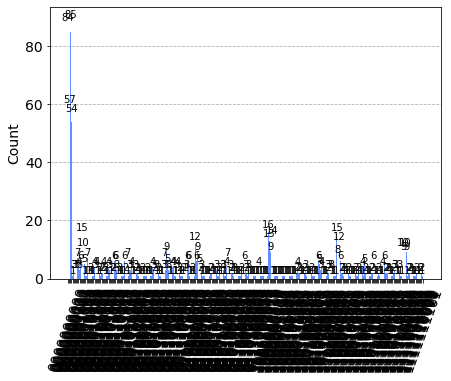

In [64]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 2048
qc_res = create_qaoa_circ(res.x,H=H,paulis_idx=paulis_idx)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

# for i,e in counts.items():
#     if e == 2:
#         counts[i] = 0

plot_histogram(counts)

In [ ]:
y = wo.Marginals(spins, N, cov, mu,0)
y = np.matrix(y).T if len(y.shape)==1 else y
x_recov = np.zeros((2**14,1))

H, paulis_idx = compute_hamiltonian(all_pat,y)

expectation = get_expectation(paulis_idx=paulis_idx,H=H)

res = minimize(expectation, 
                np.ones(20), 
                method='COBYLA')
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(res.x,paulis_idx,H)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

z = list(counts.keys())[np.argmax(list(counts.values()))]
v = BitArray(bin='0'+z).int
print(v)
good_v = v

possible_s = np.arange(0.1,0.6,0.1)

for i in range(10):

    x_recov[good_v] = A.T[good_v]*y
    values = []

    for s in possible_s:
        
        y_prime = y - s*A.T[v].T
        y_prime[y_prime<0] = 0

        a = np.zeros(16384)
        for yi,pat in zip(y_prime,all_pat):
            a+= dev_pattern(pat)*yi[0,0]
        plt.plot(np.arange(1000),a[:1000])
        plt.show()

        H, paulis_idx = compute_hamiltonian(all_pat,y_prime)

        expectation = get_expectation(paulis_idx=paulis_idx,H=H)
        res = minimize(expectation, 
                        np.ones(20), 
                        method='COBYLA')

        qc_res = create_qaoa_circ(res.x,paulis_idx,H)
        counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
        z = list(counts.keys())[np.argmax(list(counts.values()))]
        v = BitArray(bin='0'+z).int
        
        values.append(v)
    
    print(values)
    c = Counter(values)
    ma = max(c, key=c.get)
    values = np.array(values)

    good_s = possible_s[np.where(values==ma)]
    good_s = np.max(good_s)
    
    good_v = ma
    print(good_v)
    
    y -= good_s * A.T[good_v].T

# x_recov[good_v] = A.T[good_v]*y

# x_recov = list(x_recov.T[0])[:a**m]
# plt.bar(range(a**m),x_recov)
# plt.plot()

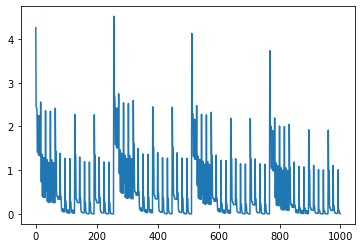

256
2


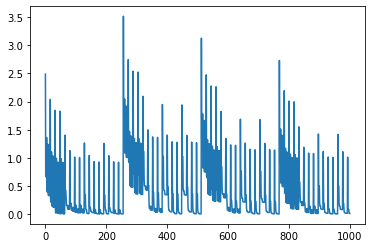

256
256


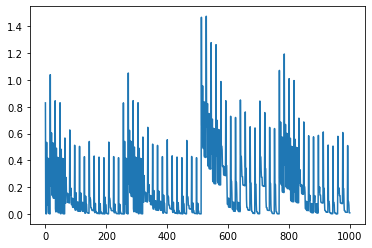

528
512


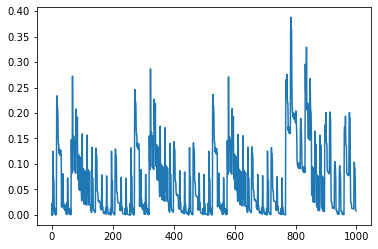

785


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [152]:
# y = wo.Marginals(spins, N, cov, mu,0)
y = np.matrix(y).T if len(y.shape)==1 else y
x_recov = np.zeros((2**14,1))

a = np.zeros(16384)
for yi,pat in zip(y,all_pat):
    a+= dev_pattern(pat)*yi[0,0]
plt.plot(np.arange(1000),a[:1000])
plt.show()
print(a.argmax())

for i in range(5):

    H, paulis_idx = compute_hamiltonian(all_pat,y)

    expectation = get_expectation(paulis_idx=paulis_idx,H=H)

    res = minimize(expectation, 
                        np.ones(20), 
                        method='COBYLA')
    backend = Aer.get_backend('aer_simulator')
    backend.shots = 512

    qc_res = create_qaoa_circ(res.x,paulis_idx,H)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

    z = list(counts.keys())[np.argmax(list(counts.values()))]

    v = BitArray(bin='0'+z).int

    print(v)

    x_recov[v] = A.T[v]*y
    y -= 0.5 * A.T[v].T
    y[y<0]=0

    a = np.zeros(16384)
    for yi,pat in zip(y,all_pat):
        a+= dev_pattern(pat)*yi[0,0]
    plt.plot(np.arange(1000),a[:1000])
    plt.show()
    print(a.argmax())

# x_recov = list(x_recov.T[0])[:a**m]
# plt.bar(range(a**m),x_recov)
# plt.plot()